In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import os

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
from sklearn.metrics import r2_score


In [7]:
from sklearn.preprocessing import StandardScaler


In [8]:
import statsmodels.api as sm


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [11]:
from sklearn.linear_model import LinearRegression


In [12]:
from sklearn.metrics import mean_absolute_error

In [13]:
from sklearn.metrics import mean_squared_error


In [14]:
from sklearn.metrics import mean_absolute_percentage_error

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler


In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
df = pd.read_csv('/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_106.csv')

In [18]:
def three_hour_df(homeid):
    df = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

    df['time'] = pd.to_datetime(df['time'])

    categorical_data = df[['time','weather_code (wmo code)']].copy()
    df.drop(columns=['weather_code (wmo code)', 'electric_combined_1h_forecast'], inplace=True)
   
    df.set_index('time', inplace=True)
    df = df.resample('3H').mean().round(2)
    categorical_data.set_index('time', inplace=True)
    categorical_data = categorical_data.resample('3H').apply(lambda x: x.mode().iloc[0])
    df['electric-combined_3H-forecast'] = df['electric-combined'].shift(-1)
    df = pd.concat([df, categorical_data], axis=1)
    df= df.dropna()

    end_col = df.pop('electric-combined_3H-forecast')
    df['electric-combined_3H-forecast'] = end_col

    if os.path.exists(f'/Users/barry/CodeAcademy/Ideal_dataset/3h_csv/hourly_{homeid}.csv'):
        print(f'file already exists for {homeid}')
    else:
        df.to_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/3h_csv/hourly_{homeid}.csv')

    return df

## i want to automate the running of this so that it runs over the entire updated 1 H folder

In [19]:
def authomated_3H_csv_maker():
    folder_path = '/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv'
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            blah = file_path.split('_')
            homeid = blah[-1][:-4]
            try:
                homeid = int(homeid)
                three_hour_df(homeid)
            except:
                pass
            

In [22]:
authomated_3H_csv_maker()

In [21]:
df_107 = three_hour_df(107)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_107.csv'

In [ ]:
def forecast(homeid):
    #lets add my time series info to the dataframe
    desired_features = ['hot-water-hot-pipe', 'gas','electric_combined_1W_lagged', 'electric-combined',
       'central-heating-flow', 'hot-water-cold-pipe',
       'temperature_2m (°C)', 'relative_humidity_2m (%)','wind_speed_10m (km/h)', 'day', 'hour', 'weather_code (wmo code)', 'electric-combined_3H-forecast']
    df = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/3h_csv/hourly_{homeid}.csv')
    df.dropna(inplace=True)
    df = df[desired_features]
    df = pd.get_dummies(df, columns=['weather_code (wmo code)'])
    y = df.pop('electric-combined_3H-forecast')


    X = df
    

    test_size = 96
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    #SCALLING DID NOT HELP
    # Create a scaler object
    # scaler = MinMaxScaler()

    # # Fit the scaler to the training data and transform it
    # X_train_scaled = scaler.fit_transform(X_train)

    # # Use the same scaler to transform the test data
    # X_test_scaled = scaler.transform(X_test)

    # train_size = int(len(df) - 96)
    # X_train = X[:train_size]
    # X_test = X[train_size:]
    # y_train = y[:train_size]
    # y_test = y[train_size:]
    

    def linear_regression_model(X_train, y_train, X_test, y_test, homeid):

        linear_model = LinearRegression()
        linear_model.fit(X_train,y_train)
        #y_pred = pd.Series(linear_model.predict(X_train), index = y_train.index)
        y_fore_poly = pd.Series(linear_model.predict(X_test), index = y_test.index)
        
        plot_data = pd.DataFrame(columns=['y_test', 'y_fore_poly'])
        plot_data['y_test'] = y_test
        plot_data['y_fore_poly'] = y_fore_poly
        plot_data = plot_data.reset_index(drop=True)
        org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')
        org_csv = org_csv['time'].tail(test_size).reset_index(drop=True)
        plot_data['time'] = org_csv        
        plot_data.set_index('time', inplace=True)
        display(plot_data)
      
        
        fig, axs = plt.subplots(figsize=(20,10))
        fig1 = sns.lineplot(data=plot_data, ax=axs, markers=True, dashes=False)
        plt.xticks(ticks= plot_data.index, rotation=90)
        axs.set_title(f'contrasting next 3 hour prediciton with actuals over 7 days: homeid {homeid}')
        plt.suptitle('Linear Regression Model')

        #lets check errors
        print('Linear Regression:')
        print(f'mean absolute error: {mean_absolute_error(y_test, y_fore_poly)}')
        print(f'mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_fore_poly)}')
        print(f'R-squared error: {r2_score(y_test, y_fore_poly)}')

        print('______________')

    #     svrgs_parameters = {
    #     'kernel': ['rbf'],
    #     'C':     [150000,200000,250000],
    #     'gamma': [0.004,0.0045,0.005]
    # }
    
    def poly_regresssion_model(X_train, y_train, X_test, y_test, homeid):
        poly = PolynomialFeatures(degree=3)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, y_train)
        y_fore_poly = poly_model.predict(X_test_poly)
        print('Polynomial regression')
        print(f'mean absolute error: {mean_absolute_error(y_test, y_fore_poly)}')
        print(f'mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_fore_poly)}')
        print(f'R-squared error: {r2_score(y_test, y_fore_poly)}')
        print('______________')
        plot_data = pd.DataFrame(columns=['y_test', 'y_fore_poly'])
        plot_data['y_test'] = y_test
        plot_data['y_fore_poly'] = y_fore_poly
        plot_data = plot_data.reset_index(drop=True)
        org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')
        org_csv = org_csv['time'].tail(test_size).reset_index(drop=True)
        plot_data['time'] = org_csv        
        plot_data.set_index('time', inplace=True)

        # org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

        
        # org_csv = org_csv['time']

        # plot_data['time'] = org_csv
        # plot_data.set_index('time', inplace=True)
        
        fig, axs = plt.subplots(figsize=(20,10))
        fig1 = sns.lineplot(data=plot_data, ax=axs, markers=True, dashes=False)
        plt.xticks(ticks= plot_data.index, rotation=90)
        axs.set_title(f'contrasting next hour 3 prediciton with actuals over 7 days: homeid {homeid}')
        plt.suptitle('Polynomial Regression Model')



    def support_vector_regression(X_train, y_train, X_test, y_test, homeid):
        from sklearn.svm import SVR
        svr = SVR()
        svr.fit(X_train, y_train)
        y_fore_svr = svr.predict(X_test)
        print('Support Vector Regression')
        print(f'mean absolute error: {mean_absolute_error(y_test, y_fore_svr)}')
        print(f'mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_fore_svr)}')
        print(f'R-squared error: {r2_score(y_test, y_fore_svr)}')
        print('______________')
        plot_data = pd.DataFrame(columns=['y_test', 'y_fore_svr'])
        plot_data['y_test'] = y_test
        plot_data['y_fore_svr'] = y_fore_svr
        plot_data = plot_data.reset_index(drop=True)
        org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')
        org_csv = org_csv['time'].tail(test_size).reset_index(drop=True)
        plot_data['time'] = org_csv        
        plot_data.set_index('time', inplace=True)

        # org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

        
        # org_csv = org_csv['time']

        # plot_data['time'] = org_csv
        # plot_data.set_index('time', inplace=True)
        
        fig, axs = plt.subplots(figsize=(20,10))
        fig1 = sns.lineplot(data=plot_data, ax=axs, markers=True, dashes=False)
        plt.xticks(ticks= plot_data.index, rotation=90)
        axs.set_title(f'contrasting next 3 hour prediciton with actuals over 7 days: homeid {homeid}')
        plt.suptitle('Support Vector Regression')
    
    def random_forest_model(X_train, y_train, X_test, y_test, homeid):
        from sklearn.ensemble import RandomForestRegressor
        rf = RandomForestRegressor()
        rf.fit(X_train, y_train)
        y_fore_rf = rf.predict(X_test)
        print('Random Forest')
        print(f'mean absolute error: {mean_absolute_error(y_test, y_fore_rf)}')
        print(f'mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_fore_rf)}')
        print(f'R-squared error: {r2_score(y_test, y_fore_rf)}')
        print('______________')
        plot_data = pd.DataFrame(columns=['y_test', 'y_fore_rf'])
        plot_data['y_test'] = y_test
        plot_data['y_fore_rf'] = y_fore_rf
        plot_data = plot_data.reset_index(drop=True)
        org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/3h_csv/hourly_{homeid}.csv')
        org_csv = org_csv['time'].tail(test_size).reset_index(drop=True)
        plot_data['time'] = org_csv        
        plot_data.set_index('time', inplace=True)

        # org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

        
        # org_csv = org_csv['time']

        # plot_data['time'] = org_csv
        # plot_data.set_index('time', inplace=True)
        
        fig, axs = plt.subplots(figsize=(20,10))
        fig1 = sns.lineplot(data=plot_data, ax=axs, markers=True, dashes=False)
        plt.xticks(ticks= plot_data.index, rotation=90)
        axs.set_title(f'contrasting next 3 hour prediciton with actuals over 7 days: homeid {homeid}')
        plt.suptitle('Random Forest Model')

    support_vector_regression(X_train, y_train, X_test, y_test, homeid)

    poly_regresssion_model(X_train, y_train, X_test, y_test, homeid)

    linear_regression_model(X_train, y_train, X_test, y_test, homeid)
        
    random_forest_model(X_train, y_train, X_test, y_test, homeid)

    


Support Vector Regression
mean absolute error: 19.038188395112936
mean absolute percentage error: 1.4111298036694008e+16
R-squared error: 0.12314390670640873
______________
Polynomial regression
mean absolute error: 52421183782.02674
mean absolute percentage error: 1.1228812544715592e+17
R-squared error: -1.5202148469761127e+20
______________


,y_test,y_fore_poly
time,,
2018-06-27 00:00:00,0.00,8.500
2018-06-27 01:00:00,0.00,18.500
2018-06-27 02:00:00,3.56,15.000
2018-06-27 03:00:00,29.64,22.125
2018-06-27 04:00:00,35.31,58.125
...,...,...
2018-06-30 19:00:00,65.39,58.750
2018-06-30 20:00:00,23.76,72.375
2018-06-30 21:00:00,35.26,59.250


Linear Regression:
mean absolute error: 8003577704033.294
mean absolute percentage error: 1.5927167307045198e+16
R-squared error: -6.665677887476509e+24
______________
Random Forest
mean absolute error: 17.542590624999995
mean absolute percentage error: 1.2280739160137088e+16
R-squared error: 0.3434389187372071
______________


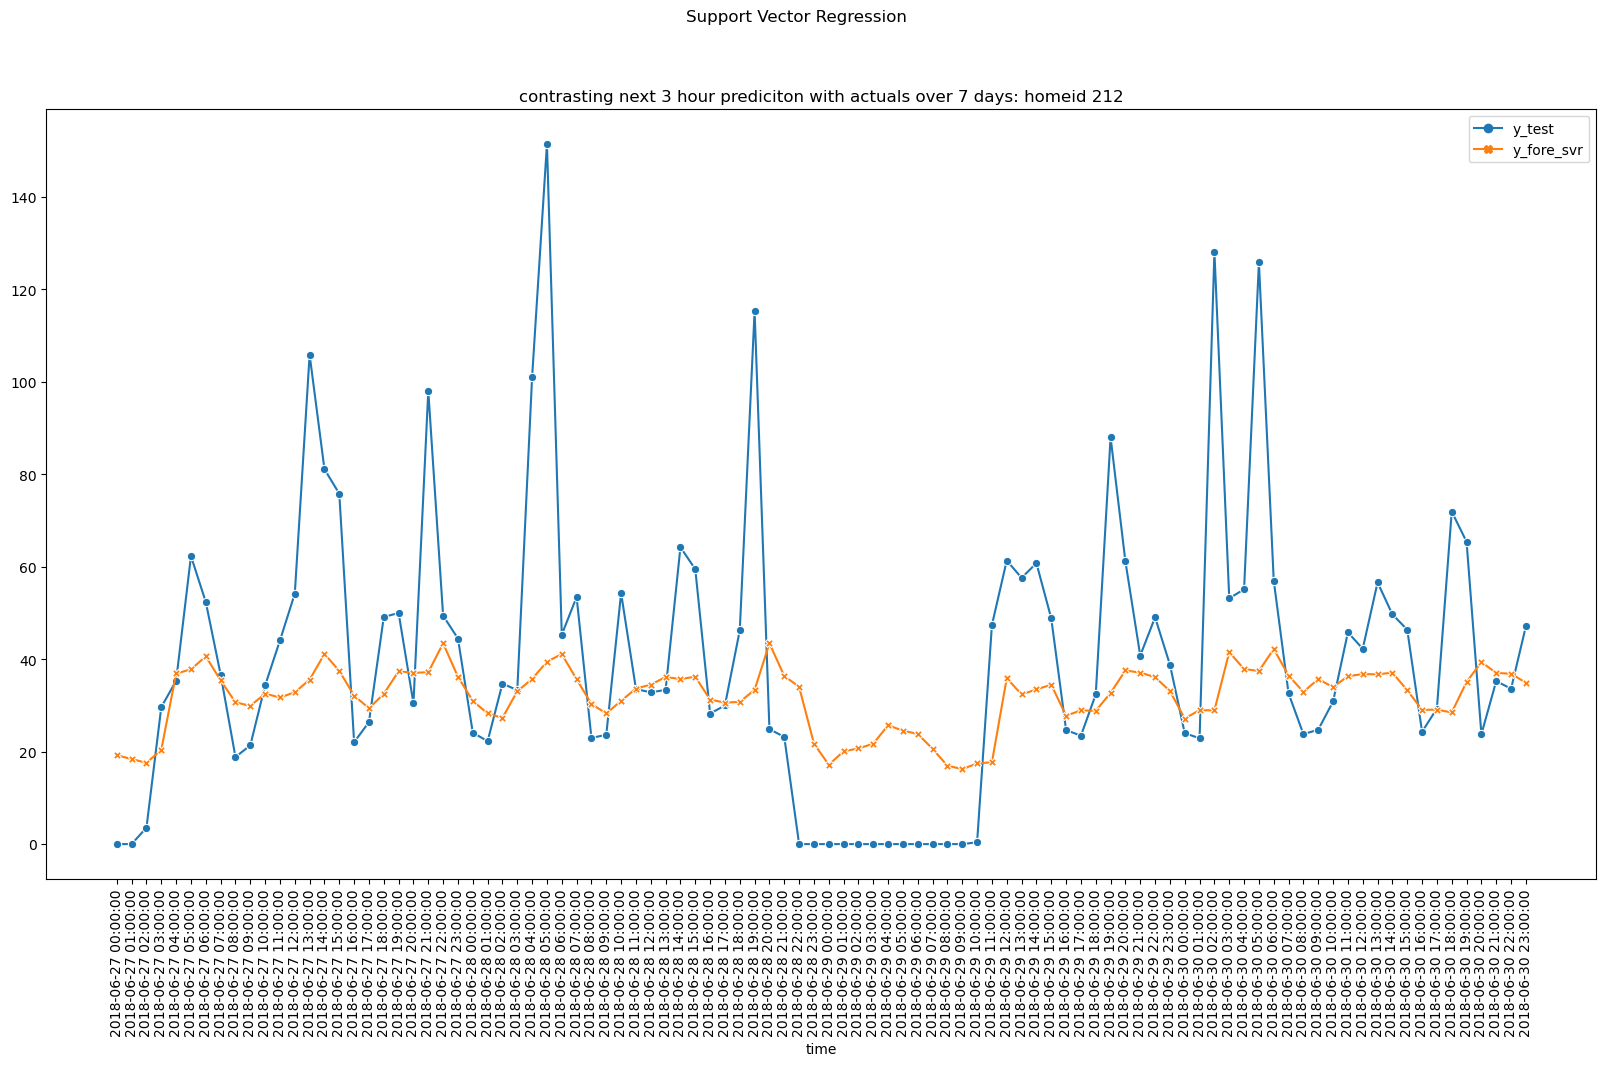

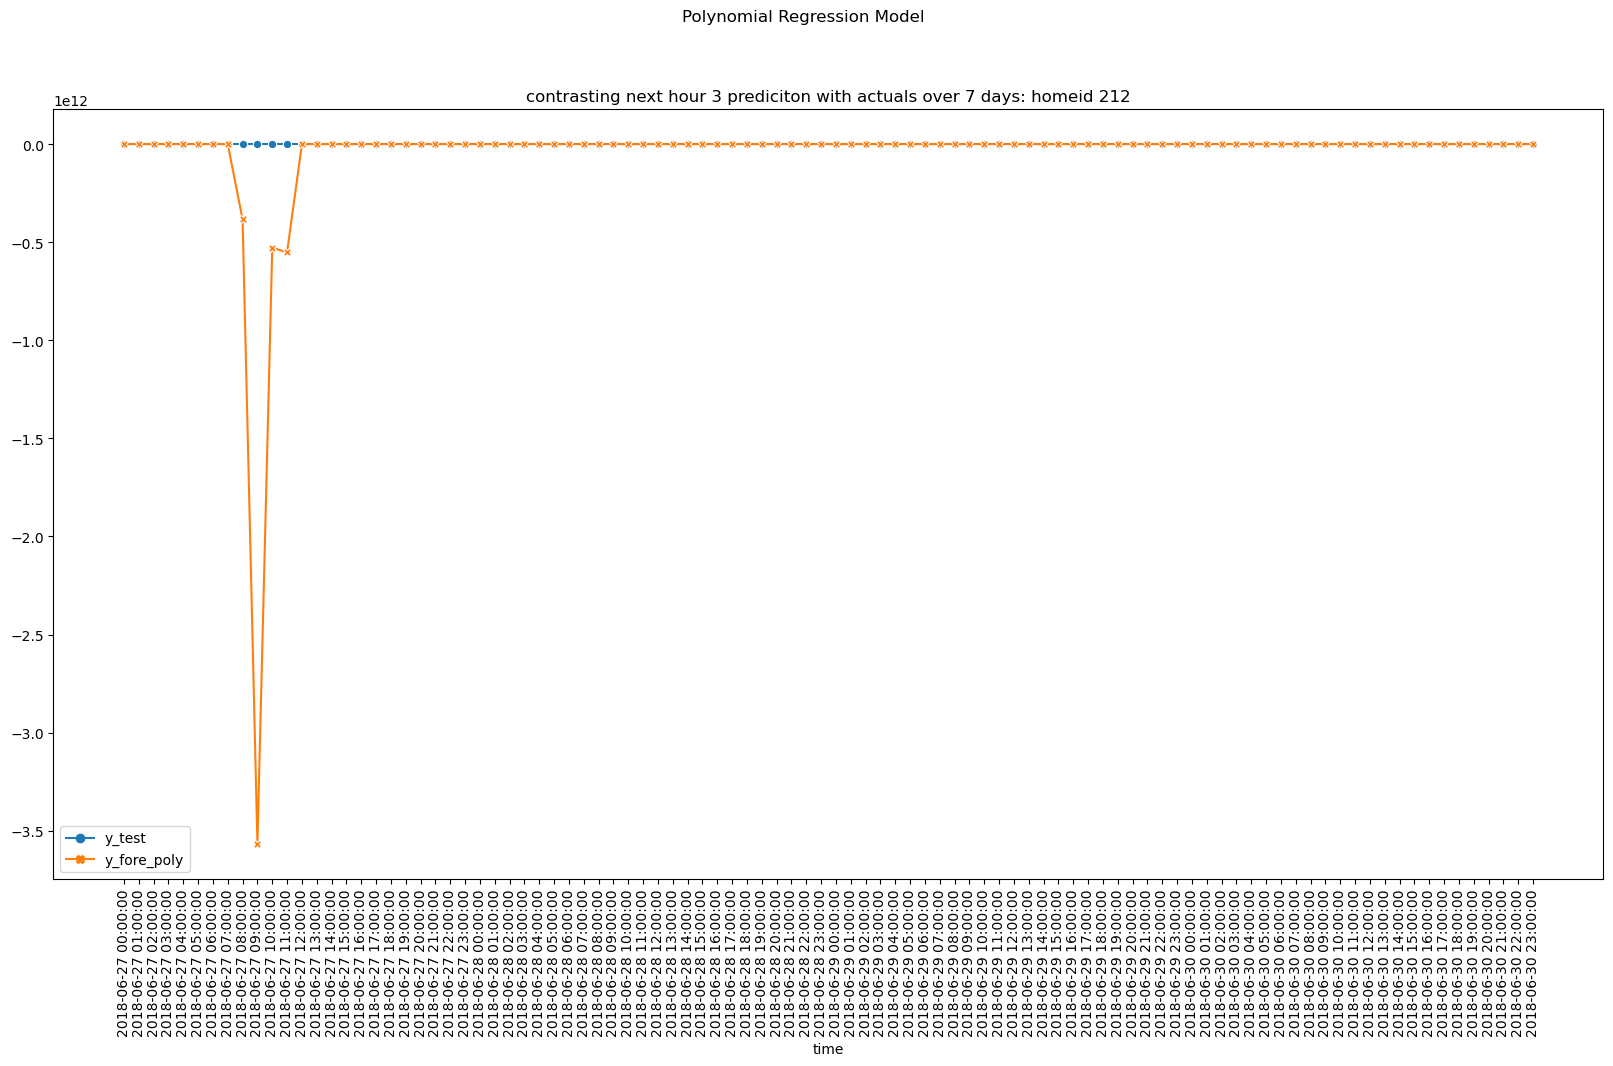

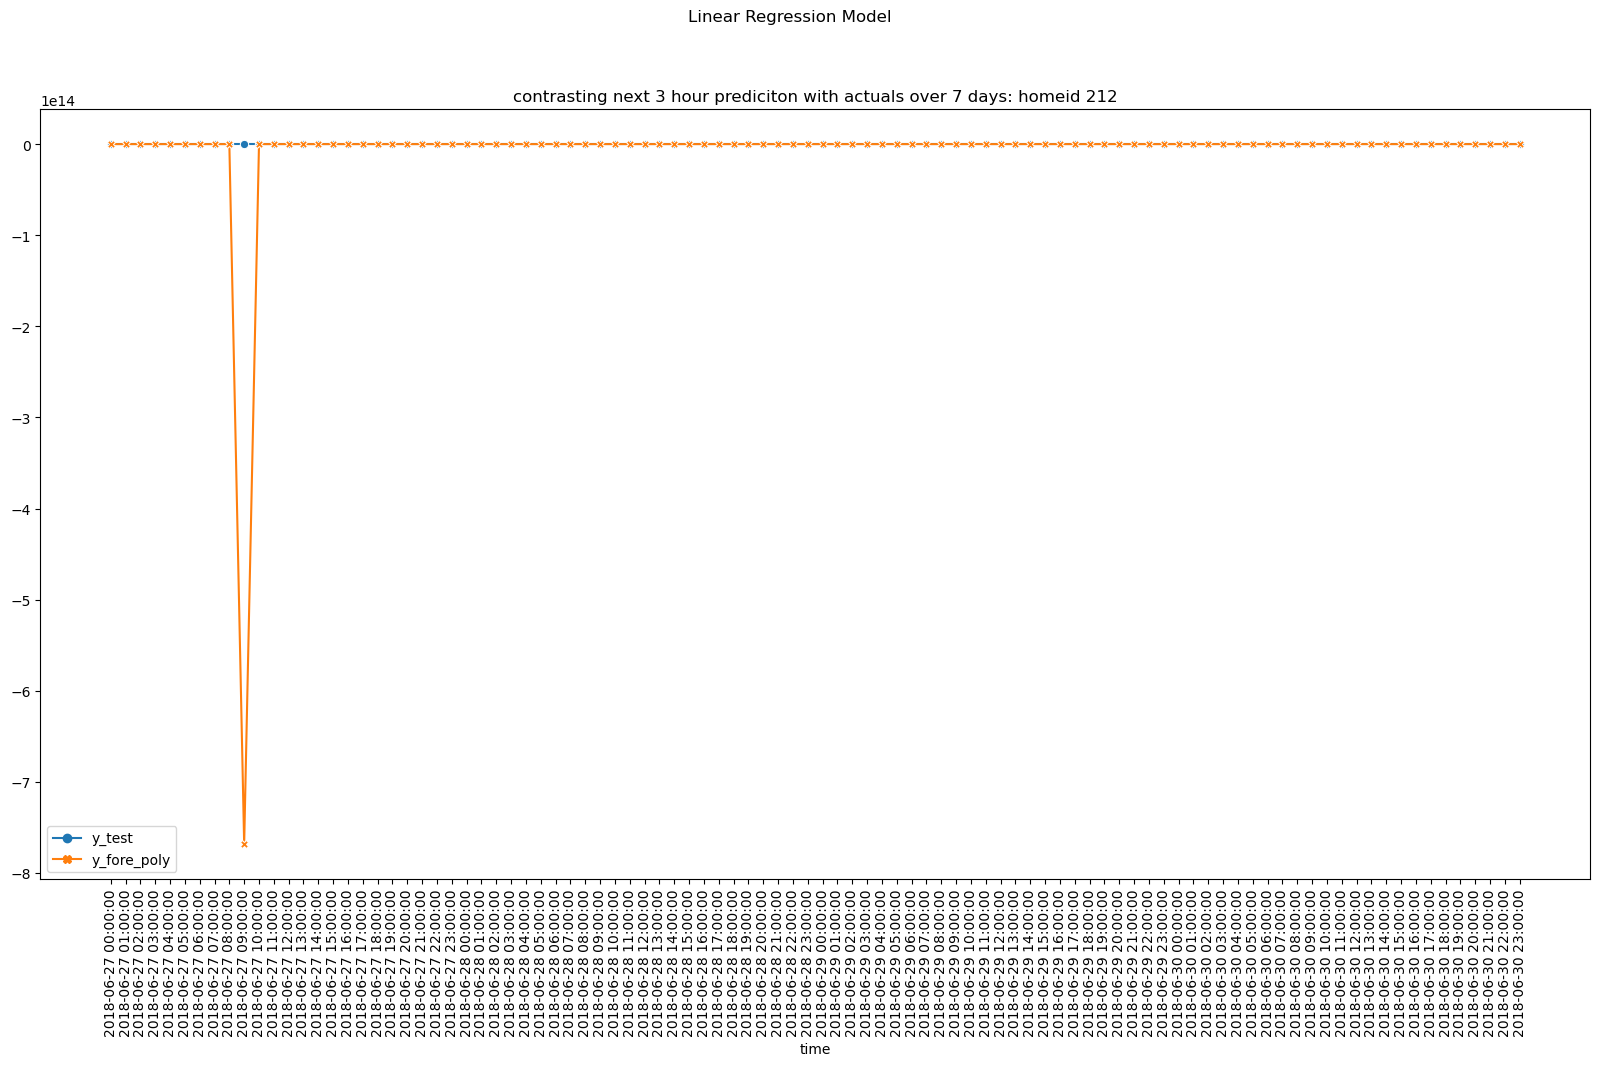

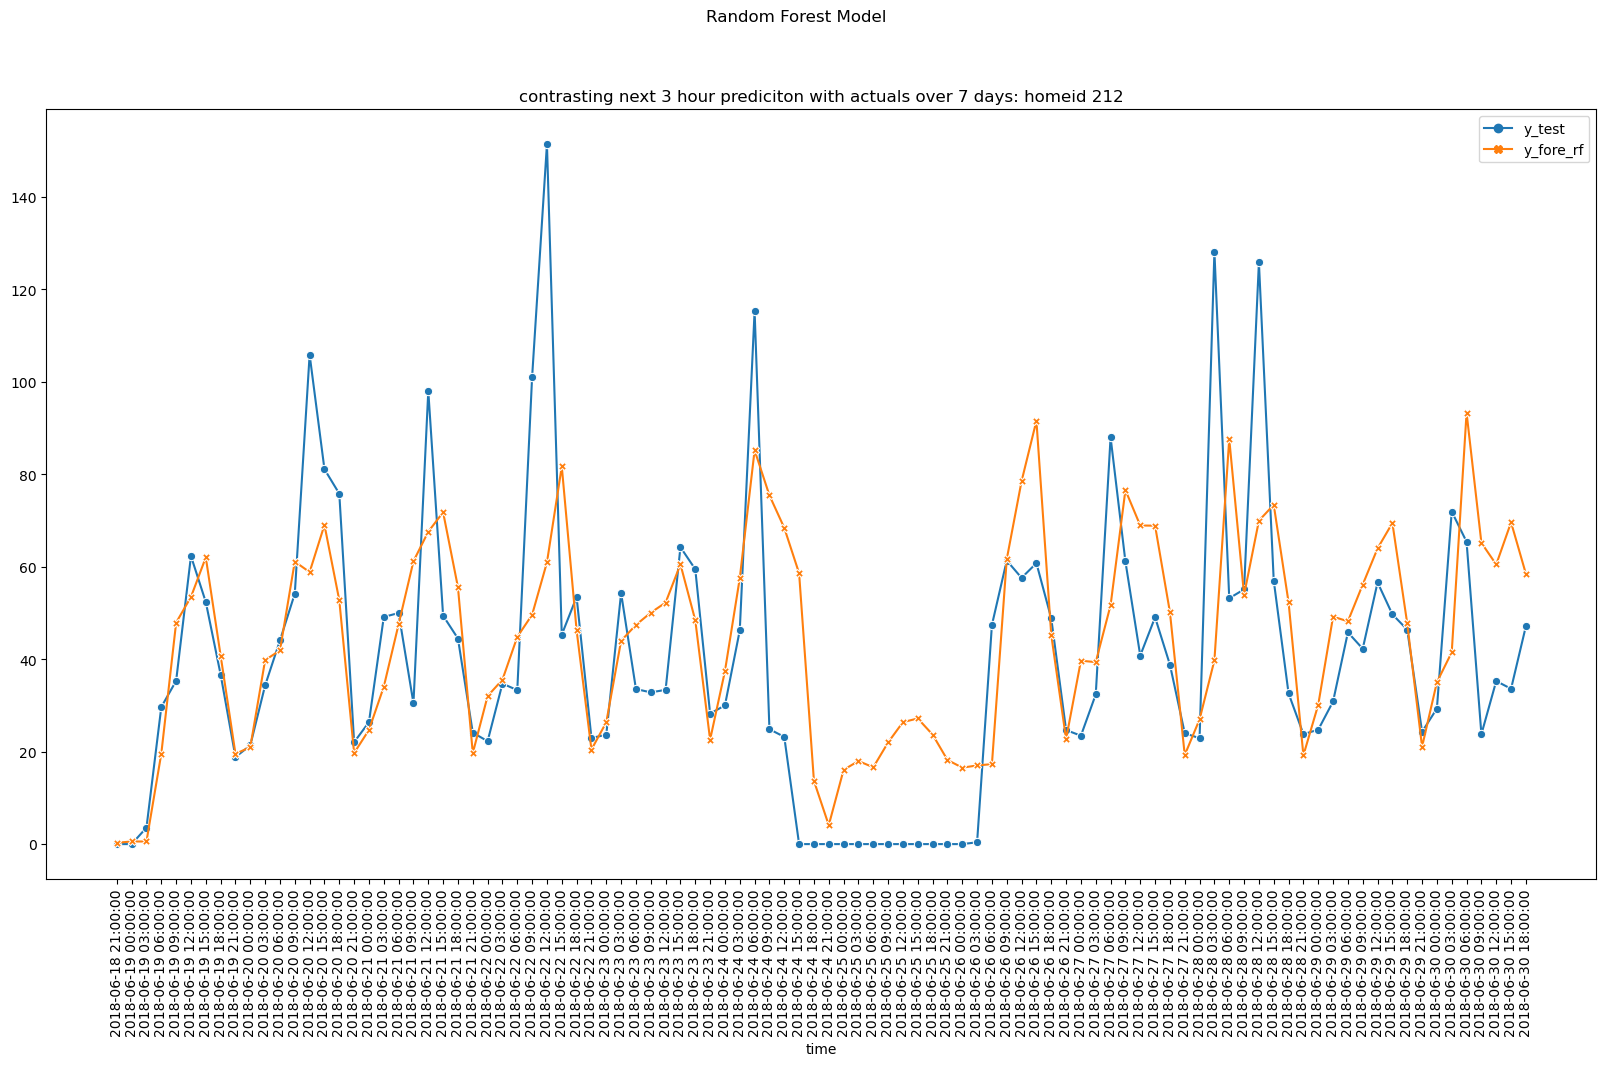

In [ ]:
forecast(212)

Support Vector Regression
mean absolute error: 17.567575643284147
mean absolute percentage error: 2432388270129015.5
R-squared error: 0.12849794668317616
______________
Polynomial regression
mean absolute error: 41.54817366723464
mean absolute percentage error: 6.836307370025251e+16
R-squared error: -4.2688354958972194
______________
Linear Regression:
mean absolute error: 21.18868746632617
mean absolute percentage error: 1.6797826046868512e+16
R-squared error: 0.1739535115793216
______________
Random Forest
mean absolute error: 18.036311458333326
mean absolute percentage error: 1.4478786635769826e+16
R-squared error: 0.33086210910909575
______________


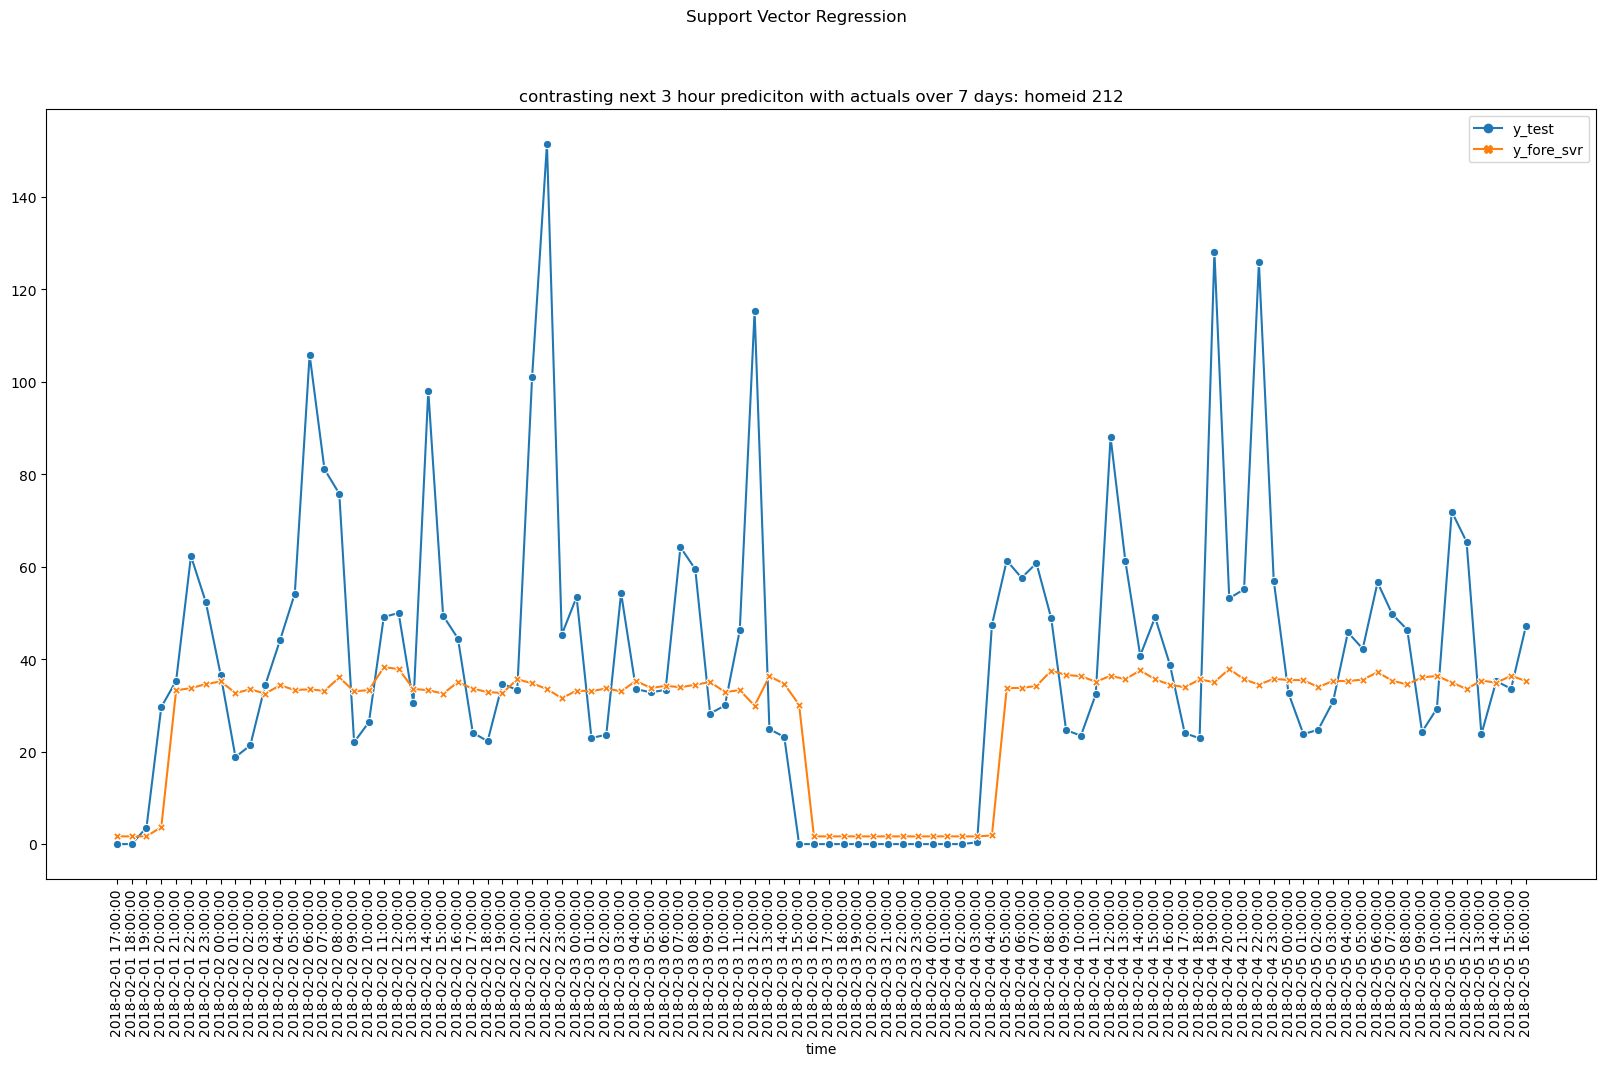

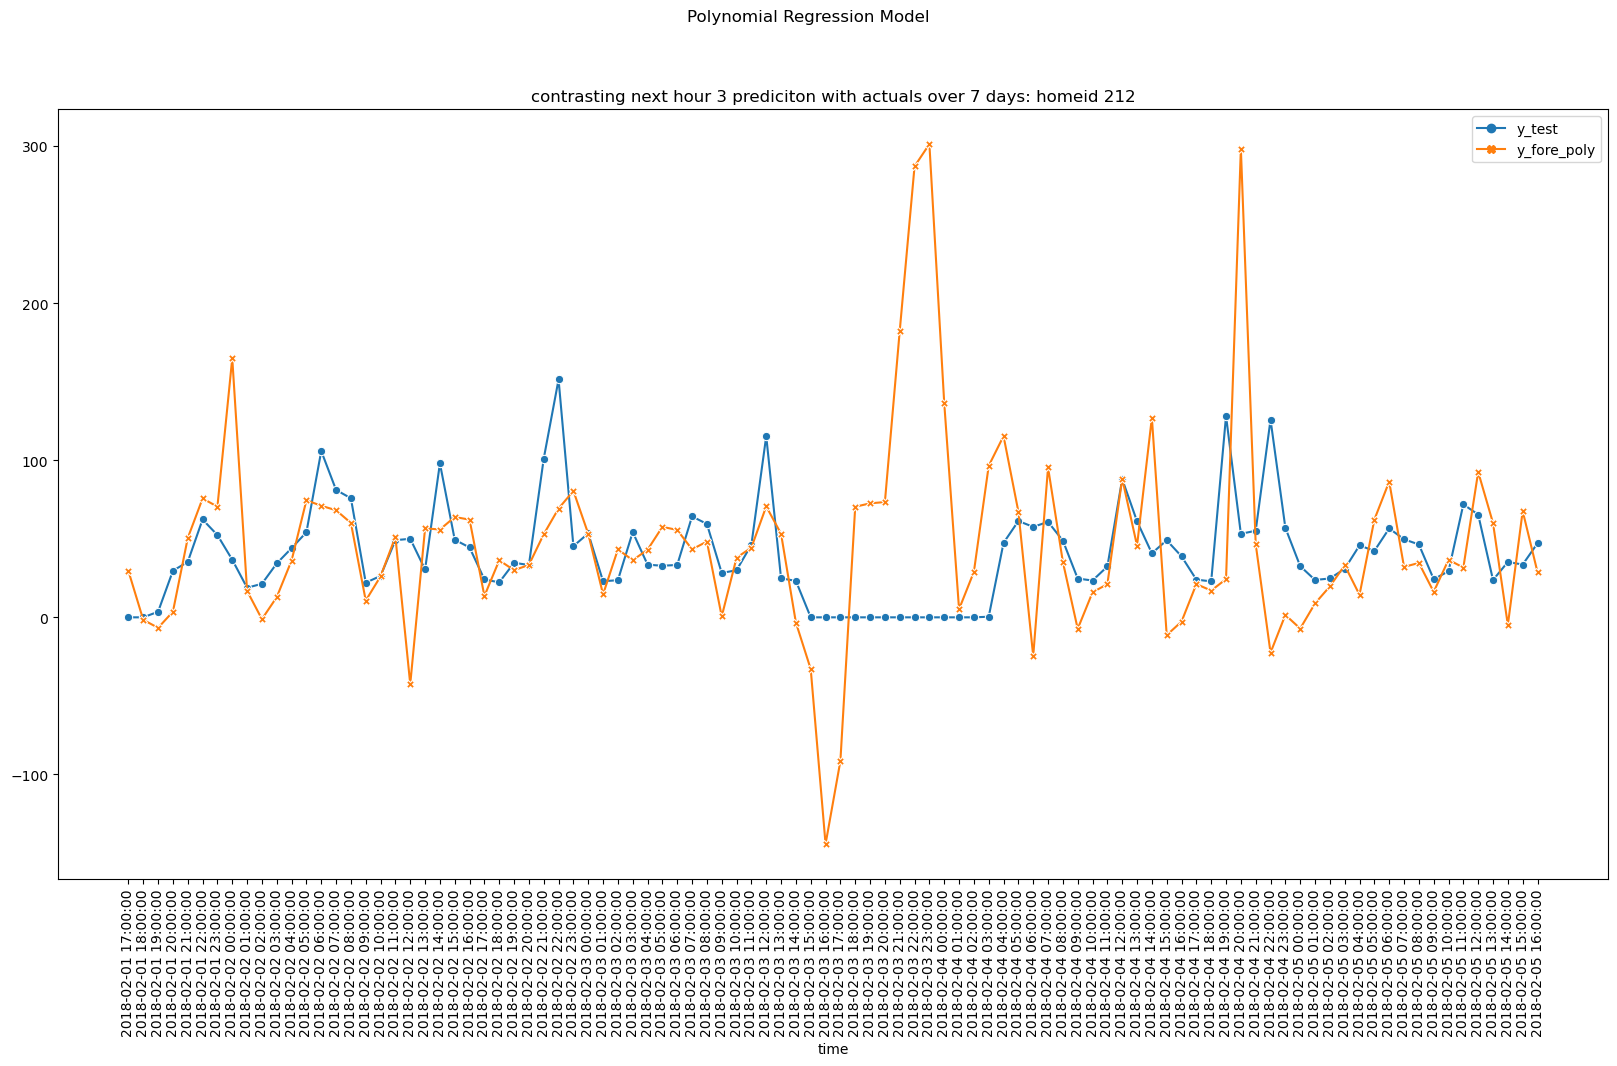

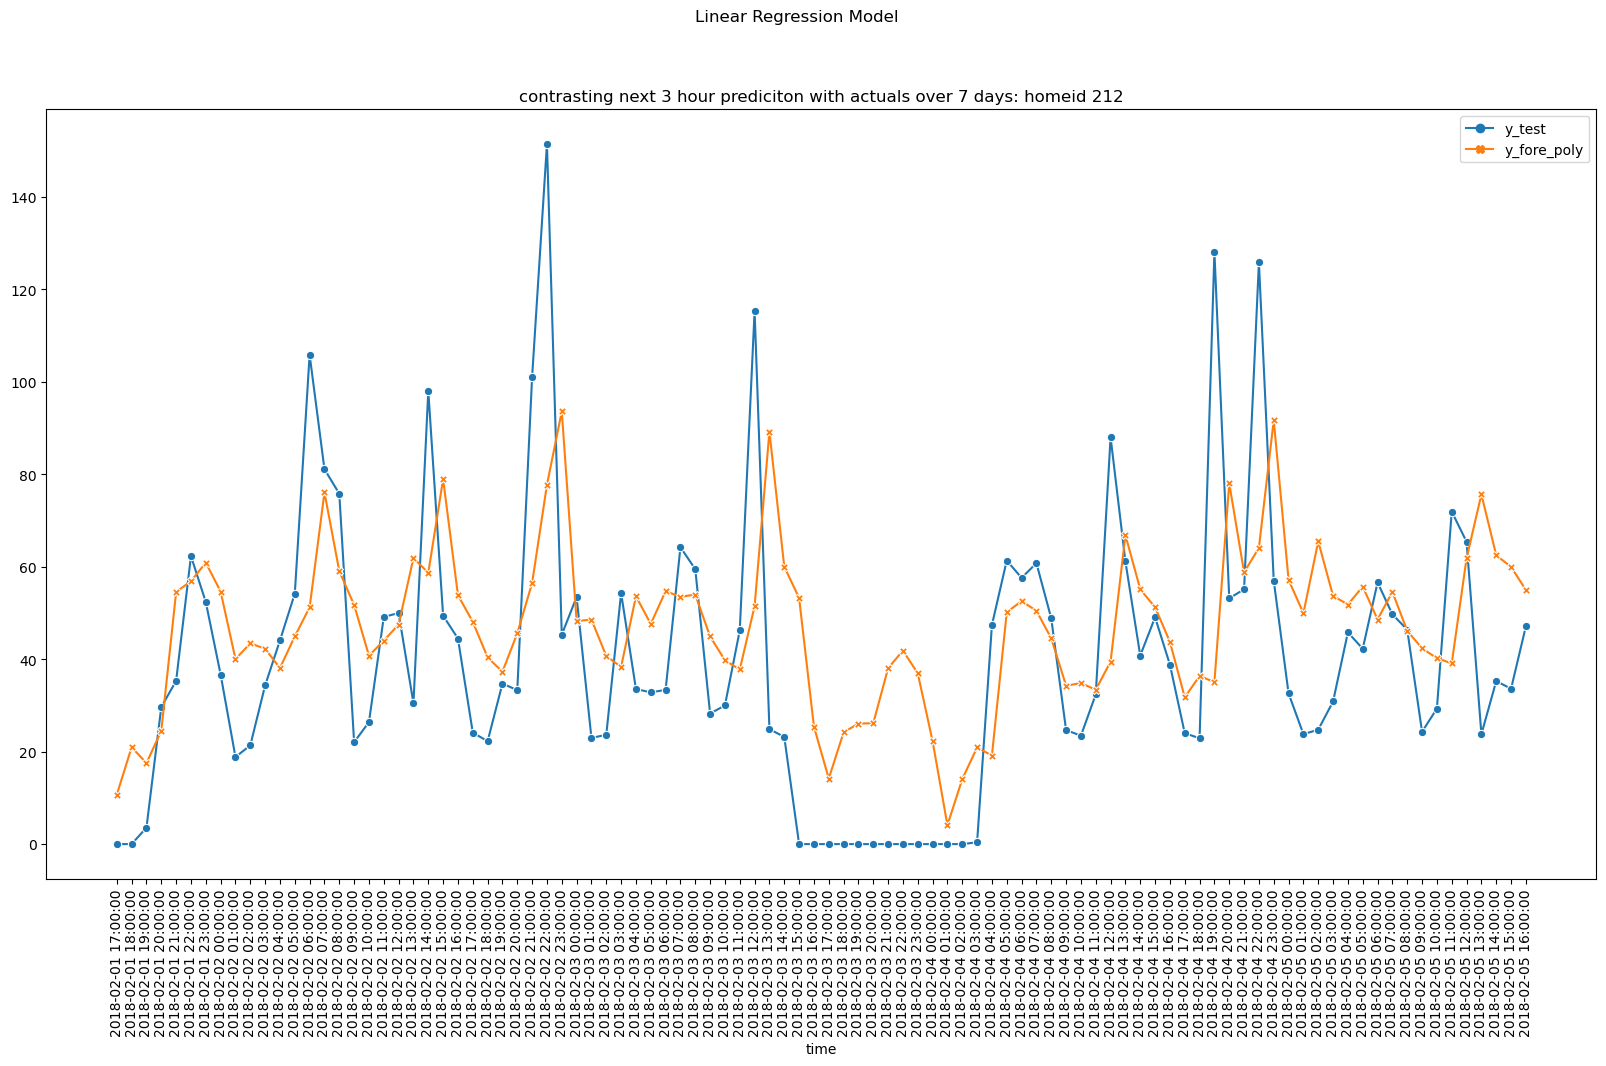

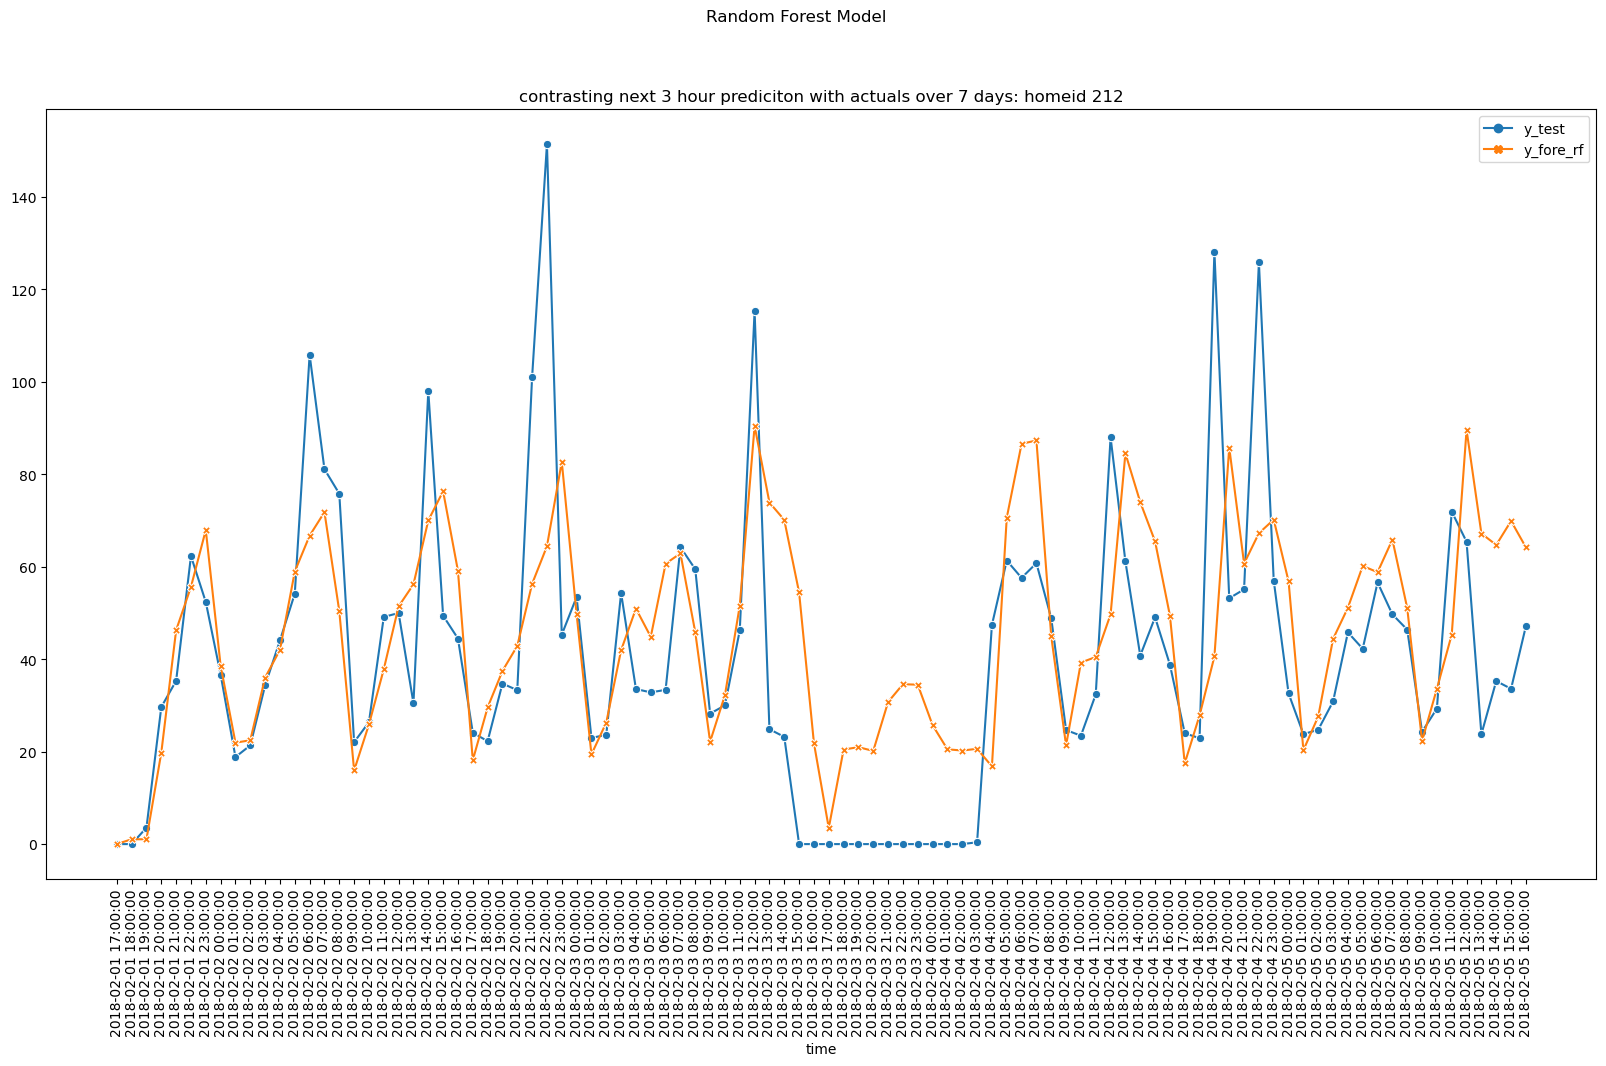

In [ ]:
forecast(212)